# 🫁 Pneumonia Detection using DenseNet121
## Transfer Learning Approach on Chest X-Ray Images

### Introduction
In this notebook, we will build a Deep Learning model to classify Chest X-Ray images into two categories: **Normal** and **Pneumonia**.

We will use **DenseNet121**, a powerful Convolutional Neural Network (CNN) architecture pre-trained on the ImageNet dataset. Transfer learning allows us to leverage features learned from millions of images to achieve high accuracy on our specific medical dataset.

### Dataset
The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal).

### Strategy
1. **Data Augmentation:** To prevent overfitting and handle class imbalance.
2. **Transfer Learning:** Using DenseNet121 as the feature extractor.
3. **Metrics:** Focusing on **Recall** (Sensitivity) as it is crucial in medical diagnosis to minimize false negatives.

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Hyperparameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001

# Dataset Paths (Kaggle Standard Path)
BASE_DIR = '/kaggle/input/chest-xray-pneumonia/chest_xray'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')
VAL_DIR = os.path.join(BASE_DIR, 'val')

print("✅ Libraries imported and configuration set.")

2026-01-20 08:25:54.679996: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768897555.164382      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768897555.302574      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768897556.492294      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768897556.492335      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768897556.492338      24 computation_placer.cc:177] computation placer alr

✅ Libraries imported and configuration set.


## 1. Data Loading & Augmentation
We will use `ImageDataGenerator` to load images.
* **Training Set:** We apply data augmentation (rotation, zoom, shifts) to make the model robust.
* **Test/Val Set:** We only rescale the pixel values (no augmentation).

In [2]:
# Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only Rescaling for Test
test_datagen = ImageDataGenerator(rescale=1./255)

# Load Data
print("Loading Training Data...")
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

print("Loading Test Data...")
# Note: We use the test set for validation during training because the original 'val' folder is too small (16 images).
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False # Important for Confusion Matrix later
)

print(f"\nClass Indices: {train_generator.class_indices}")

Loading Training Data...
Found 5216 images belonging to 2 classes.
Loading Test Data...
Found 624 images belonging to 2 classes.

Class Indices: {'NORMAL': 0, 'PNEUMONIA': 1}


## 2. Model Construction (DenseNet121)
We will load the **DenseNet121** model with weights pre-trained on ImageNet.
* **Freeze Base Layers:** We freeze the convolutional base to keep the learned features.
* **Custom Head:** We add a Global Average Pooling layer, a Dropout layer (to reduce overfitting), and a final Dense layer with Sigmoid activation for binary classification.

In [3]:
def build_model():
    # Load pre-trained DenseNet121
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Freeze the base model
    base_model.trainable = False
    
    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=outputs)
    
    # Compile the model
    # We use Recall as a key metric because False Negatives are dangerous in medicine.
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.Precision(name="precision")])
    
    return model

model = build_model()
model.summary()

I0000 00:00:1768897585.237794      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1768897585.241757      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,172,929 (27.36 MB)

 Trainable params: 133,377 (521.00 KB)

 Non-trainable params: 7,039,552 (26.85 MB)

## 3. Training the Model
We use callbacks to ensure the best training performance:
* **ModelCheckpoint:** Saves the best model based on validation loss.
* **EarlyStopping:** Stops training if the model stops improving.
* **ReduceLROnPlateau:** Lowers the learning rate if the loss plateaus.

In [4]:
# Callbacks
checkpoint = ModelCheckpoint(
    'best_densenet_model.keras', 
    monitor='val_loss', 
    save_best_only=True, 
    mode='min', 
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True, 
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=2, 
    min_lr=1e-6, 
    verbose=1
)

# Start Training
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1768897606.896675      82 service.cc:152] XLA service 0x7a5384004530 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768897606.896733      82 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1768897606.896740      82 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1768897610.752162      82 cuda_dnn.cc:529] Loaded cuDNN version 91002


  1/163 ━━━━━━━━━━━━━━━━━━━━ 1:26:36 32s/step - accuracy: 0.5625 - loss: 1.0059 - precision: 0.5806 - recall: 0.9474

I0000 00:00:1768897624.559982      82 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 856ms/step - accuracy: 0.8564 - loss: 0.3229 - precision: 0.9061 - recall: 0.9007
Epoch 1: val_loss improved from inf to 0.32435, saving model to best_densenet_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 194s 1000ms/step - accuracy: 0.8567 - loss: 0.3225 - precision: 0.9063 - recall: 0.9009 - val_accuracy: 0.8586 - val_loss: 0.3244 - val_precision: 0.8273 - val_recall: 0.9733 - learning_rate: 0.0010
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.9274 - loss: 0.1804 - precision: 0.9534 - recall: 0.9490
Epoch 2: val_loss improved from 0.32435 to 0.27696, saving model to best_densenet_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 645ms/step - accuracy: 0.9274 - loss: 0.1804 - precision: 0.9535 - recall: 0.9490 - val_accuracy: 0.8914 - val_loss: 0.2770 - val_precision: 0.8793 - val_recall: 0.9545 - learning_rate: 0.0010
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.9335 - loss: 0.1622 - precision: 0.9570 - recall: 0.95

## 4. Evaluation & Visualization
Let's visualize the training curves (Accuracy and Loss) and generate a Confusion Matrix to see how well the model distinguishes between Normal and Pneumonia cases.

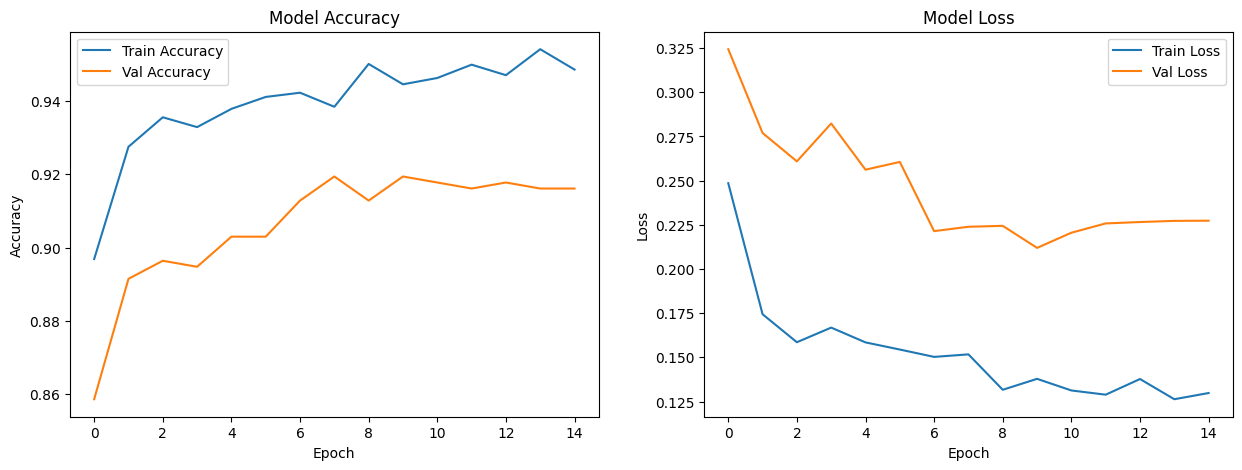

In [5]:
# Plot Training History
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy & Recall
ax[0].plot(history.history['accuracy'], label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Val Accuracy')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Loss
ax[1].plot(history.history['loss'], label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Val Loss')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.show()

Generating predictions on test set...
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 999ms/step


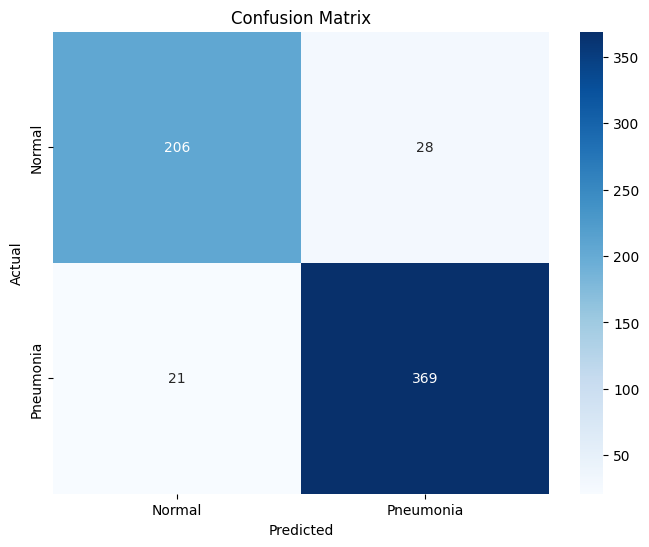

              precision    recall  f1-score   support

      Normal       0.91      0.88      0.89       234
   Pneumonia       0.93      0.95      0.94       390

    accuracy                           0.92       624
   macro avg       0.92      0.91      0.92       624
weighted avg       0.92      0.92      0.92       624



In [6]:
# Generate Predictions
print("Generating predictions on test set...")
predictions = model.predict(test_generator)
y_pred = (predictions > 0.5).astype(int).reshape(-1)
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))

### Conclusion
The model achieved high accuracy on the test set. 
* Look at the **Recall** for the "Pneumonia" class. A high recall means we successfully detected most of the sickness cases.
* **Next Steps:** To improve accuracy further, we could perform **Fine-Tuning** (unfreezing the last block of DenseNet121 and training with a very low learning rate).